## This script runs all necessary scenarios and output collections for figure 3 and constructs figure 3

In [1]:
# Import all things necessary
from scenario_class import Scenario
from plots_class import Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib.cm as cm
from scenariosweeper_class import ScenarioSweeper
import matplotlib.gridspec as gridspec

this is the threshold_norm 0.3161304682073965
this is the below_colors [[0.27058824 0.45882353 0.70588235 1.        ]
 [0.27409458 0.4622376  0.70768166 1.        ]
 [0.27760092 0.46565167 0.70948097 1.        ]
 [0.28110727 0.46906574 0.71128028 1.        ]
 [0.28461361 0.47247982 0.71307958 1.        ]
 [0.28928874 0.47703191 0.71547866 1.        ]
 [0.29279508 0.48044598 0.71727797 1.        ]
 [0.29630142 0.48386005 0.71907728 1.        ]
 [0.29980777 0.48727413 0.72087659 1.        ]
 [0.30448289 0.49182622 0.72327566 1.        ]
 [0.30798923 0.49524029 0.72507497 1.        ]
 [0.31149558 0.49865436 0.72687428 1.        ]
 [0.31500192 0.50206844 0.72867359 1.        ]
 [0.31967705 0.50662053 0.73107266 1.        ]
 [0.32318339 0.5100346  0.73287197 1.        ]
 [0.32668973 0.51344867 0.73467128 1.        ]
 [0.33019608 0.51686275 0.73647059 1.        ]
 [0.3348712  0.52141484 0.73886967 1.        ]
 [0.33837755 0.52482891 0.74066897 1.        ]
 [0.34188389 0.52824298 0.74246828 1

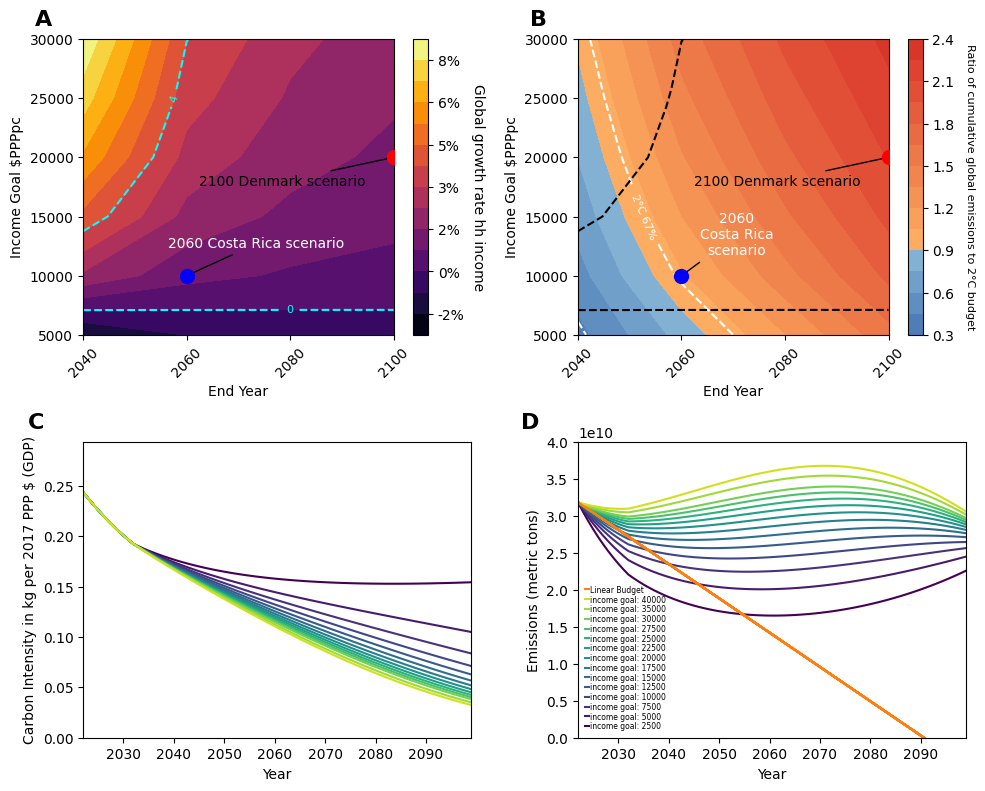

In [2]:
# Create a figure
fig = plt.figure(figsize=(10, 8))

# Define a GridSpec for a 2x2 grid
gs = gridspec.GridSpec(2, 2, figure=fig)

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])  # Top-left
ax2 = fig.add_subplot(gs[0, 1])  # Top-right
ax3 = fig.add_subplot(gs[1, 0])  # Bottom-left
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right


# calculate how much emissions are emitted in a given scenario run and how far above this is the carbon budget by summing the yearly emissions of all countries
# Example usage:
end_year_values = [2040, 2060, 2080, 2100]
income_goal_values = [5000, 10000, 15000, 20000, 25000, 30000]
carbon_budget_values = [1150*0.95 - 2*35] # 95% of the carbon budget because of 95% population coverage and minus two years because first model year is 2023 and the budgets are from 2020 onwards
hysteresis_tech_progress_values = [0.01] # this is a growth rate, so between 0 and 1, which only applies if tech_hysteresis_assumption is on
gdp_assumption_values = ["constant_ratio"]
pop_growth_assumption_values = ["semi_log_model"]
tech_evolution_assumption_values = ["plausible"]
tech_hysteresis_assumption_values = ["off"]
steady_state_high_income_assumption_values = ["off"]
sweeper1 = ScenarioSweeper(end_year_values,
                           income_goal_values,
                           carbon_budget_values,
                           hysteresis_tech_progress_values,
                           gdp_assumption_values,
                           pop_growth_assumption_values,
                           tech_evolution_assumption_values,
                           tech_hysteresis_assumption_values,
                           steady_state_high_income_assumption_values)


output = sweeper1.run_scenarios() 
# output[0] is the emissions and output[1] is the gdp growth rate globally
input1 = output[0] # output now will be transformed to an input for the plots function
input2 = output[1] # output now will be transformed to an input for the plots function
# Create a new figure with four axes
sweeper1.plot_total_emissions_trade_off(input1, ["end_year", "income_goal"], ax = ax2, fixed_color_scale=False, annotations_plot = True, colorscaleon = True)
sweeper1.plot_growth_rate_trade_off(input2, ["end_year", "income_goal"], ax1)

# create a list of income goals
income_goals = [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000, 35000, 40000]

# create colormap and map to income goals
colors = cm.viridis([i/len(income_goals) for i in range(len(income_goals))])    

# Plot global emissions pathways
for income_goal in income_goals:
    scenario_params = {
        "end_year": 2100,
        "income_goal": income_goal,
        "carbon_budget": 1150*0.95, # 95% of the carbon budget because of 95% population coverage
        "hysteresis_tech_progress": 0.01, # this is a growth rate, so between 0 and 1, which only applies if tech_hysteresis_assumption is on
        "gdp_assumption": "constant_ratio",
        "pop_growth_assumption": "semi_log_model",
        "tech_evolution_assumption": "plausible",
        "tech_hysteresis_assumption": "off", # turn off tech hysteresis for this plot
        "steady_state_high_income_assumption": "off"
    }

    scenario_1 = Scenario(scenario_params)
    scenario_1.compute_country_scenario_params()
    scenario_1.run()
    plotting_1 = Plots(scenario_1)
    # Plot the results
    plotting_1.plot_global_emissions(ax=ax4,
                                    color=colors[income_goals.index(income_goal)],
                                    label="income goal: " + str(income_goal))
    # Plot the results
    plotting_1.plot_global_carbon_intensity(ax=ax3,
                                            color=colors[income_goals.index(income_goal)],
                                            label="income goal: " + str(income_goal))


# Collect all legend handles and labels for global emissions pathways
handles1, labels1 = ax4.get_legend_handles_labels()

# Find unique labels and their handles, maintaining original order
unique_labels_handles1 = dict()
for label, handle in zip(labels1, handles1):
    if label not in unique_labels_handles1:
        unique_labels_handles1[label] = handle

# Prepare lists for sorted labels and their corresponding handles
sorted_labels1 = []
sorted_handles1 = []

# Add the "Linear Carbon Budget Pathway" first if it exists
if "Linear Budget" in unique_labels_handles1:
    sorted_labels1.append("Linear Budget")
    sorted_handles1.append(unique_labels_handles1["Linear Budget"])

# Process and sort income goal labels in descending order
income_goals_labels1 = [(label, handle) for label, handle in unique_labels_handles1.items() if label.startswith("income goal")]
# Sort based on the integer value extracted from the label
income_goals_labels1.sort(key=lambda x: int(x[0].split(": ")[1]), reverse=True)

# Append sorted income goal labels and their handles
sorted_labels1 += [label for label, _ in income_goals_labels1]
sorted_handles1 += [handle for _, handle in income_goals_labels1]

# Create the legend for global emissions pathways
ax4.legend(sorted_handles1, sorted_labels1, frameon=False, loc='lower left', fontsize=5.5,
           handlelength=0.5, handletextpad=0.2, labelspacing=0.1)

# Set y-axis limit for global emissions pathways
ax4.set_ylim(0, 4*1e10)

# Collect all legend handles and labels for carbon intensity pathways
handles2, labels2 = ax1.get_legend_handles_labels()

# Find unique labels and their handles, maintaining original order
unique_labels_handles2 = dict()
for label, handle in zip(labels2, handles2):
    if label not in unique_labels_handles2:
        unique_labels_handles2[label] = handle

# Prepare lists for sorted labels and their corresponding handles
sorted_labels2 = []
sorted_handles2 = []

# Process and sort income goal labels in descending order
income_goals_labels2 = [(label, handle) for label, handle in unique_labels_handles2.items() if label.startswith("income goal")]
# Sort based on the integer value extracted from the label
income_goals_labels2.sort(key=lambda x: int(x[0].split(": ")[1]), reverse=True)

# Append sorted income goal labels and their handles
sorted_labels2 += [label for label, _ in income_goals_labels2]
sorted_handles2 += [handle for _, handle in income_goals_labels2]

# Labeling the panels
labels = ['A', 'B', 'C', 'D']
axes = [ax1, ax2, ax3, ax4]

for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()
# save the figure at high resolution
plt.savefig("fig3.png", dpi=300)
plt.show()